In [157]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
import scipy.linalg as la

from scipy.linalg import expm
from qiskit.quantum_info import Statevector, partial_trace, Operator, DensityMatrix
from qiskit.visualization import plot_state_qsphere, plot_histogram, plot_bloch_multivector

np.set_printoptions(precision=3)

In [150]:
def init_hamiltonian(N):
    """The uniform matrix"""
    v = np.ones((N,1))*(1/np.sqrt(N))
    return np.matmul(v, v.T.conj())

def init_vector(N):
    return np.ones((N,1))*(1/np.sqrt(N))
    
def problem_vector(N):
    pv = np.zeros((N,1))
    pv[N-1] = 1
    return pv
    
def problem_hamiltonian(N):
    pv = problem_vector(N)
    return np.matmul(pv, pv.T.conj())

def H_op(delt, n, H):
    """
    Input:
        delt: time interval
        n: number of qubits
        H: Hamiltonian matrix
    return Operator exp(-itH)
    """
    H = H*(-1j*delt)
    exp_H = expm(H)
    h = QuantumCircuit(n, name = 'H_op')
    h.unitary(exp_H, range(n))
    return h.to_gate()

def f(t, epsilon, N):
    """
    Time evolve function
    Input:
        t: time point
        epsilon: error value
        N: 2**n
    return value from 0 to 1
    """
    arg = ((2*epsilon*np.sqrt(N-1)*t)/N - np.arctan(np.sqrt(N-1)))
    num = np.tan(arg) / np.sqrt(N-1)
    den = 1 + num
    result = 0.5 * den
    return result

def getT(epsilon, N):
    t1 = 1/(2*epsilon)
    t2 = N/np.sqrt(N-1)
    t3 = np.arctan((np.sqrt(N-1)))+np.arctan(np.sqrt(N-1))
    return t1*t2*t3

def getR(epsilon, N):
    """get the total iteration R"""
    return (int)(np.sqrt(N)/(epsilon**3))

def st_out(qc, n):
    """get the adjusted statevector"""
    out = Statevector.from_instruction(qc)
    out_red = partial_trace(out, [n])
    prob, st_all = la.eig(out_red.data)
    cond = (prob>0.99) & (prob<1.01)
    st = st_all[:, cond].ravel()
    return Statevector(st)

def getEpsilon(v1, v2):
    """return from 0 to 1"""
    n1 = np.matmul(v1.T.conj(), v2)
    return abs(n1)*abs(n1)

Total time T: 10.890755400276705
Total iteration R: 32
[0.295]


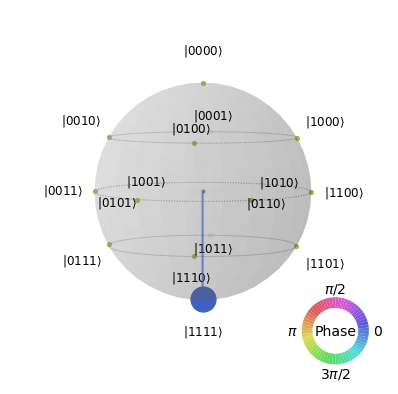

In [41]:
n = 4
N = 2**n
epsilon = 0.5

rs = []
es = []

T = getT(epsilon, N)
R = getR(epsilon, N)

circ = QuantumCircuit(n)
circ.h(range(n))

for r in range(0, R):
    t = r*(T/R)
    H0 = np.identity(N) - init_hamiltonian(N)
    Hp = np.identity(N) - problem_hamiltonian(N)
    circ.append(H_op(T/R,n,(1-f(t,epsilon,N))*H0), range(n))
    circ.append(H_op(T/R,n,f(t,epsilon,N)*Hp), range(n))

    rs.append(r)
    es.append(getEpsilon(Statevector(circ).data, problem_vector(N)))

print("Total time T: " +str(T))
print("Total iteration R: " +str(R))
print(getEpsilon(Statevector(circ).data, problem_vector(N)))
plot_state_qsphere(Statevector(circ))

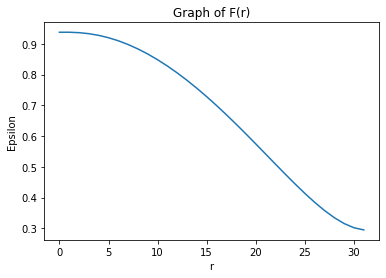

In [42]:
plt.plot(rs, es)
plt.xlabel('r')
plt.ylabel('Epsilon')
plt.title('Graph of F(r)')
plt.show()

# Using reduction

In [152]:
# def r_v0():
#     return np.array([1,0]).T
#
# def r_H0(N):
#     return np.identity(N)-np.matmul(r_v0(), r_v0().T.conj())
#
# def r_m():
#     return np.array([0,1]).T
#
# def r_Hp(N):
#     return np.identity(N)-np.matmul(r_m(), r_m().T.conj())

def get_g1(delt, f):
    H = -1j*delt*f
    return np.exp(H)

def get_g2(delt, f):
    H = -1j*delt*(1-f)
    return np.exp(H)

def get_H(a, delt, f):
    g1 = get_g1(delt, f)
    g2 = get_g2(delt, f)
    matrix = np.array([[g1+(a**2)*(1-g1)*(1-g2), a*(1-g2)],
                       [a*g2*(1-g1),  g2      ]], dtype=complex)
    return matrix

def norm(v):
    return np.sqrt(np.matmul(v.T.conj(), v)[0][0])

def normalize_vector(a):
    a_oo = a - a.real.min() - 1j*a.imag.min() # origin offsetted
    return a_oo/np.abs(a_oo).max()

In [85]:
delt = 0.12
f = 1
H = -1j*delt*f
print(np.exp(H))

(0.9928086358538663-0.11971220728891936j)


delt: 0.36422382546735715
[[0.+0.625j]
 [1.+0.j   ]]
(1.1791548264887484+0j)


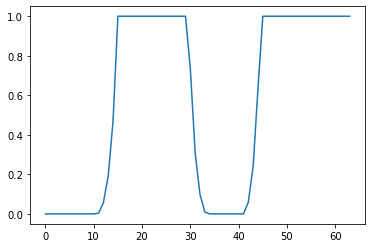

In [156]:
n = 6
N = 2**n
epsilon = 0.5

states = []
rs = []
es = []
ns = []

T = getT(epsilon, N)
R = getR(epsilon, N)
a = 1/np.sqrt(N)
delt = T/R
print("delt: " + str(delt))
state = init_vector(2)
for r in range(0, R):
    t = r*(T/R)
    H = get_H(a, delt, f(t, epsilon, N))
    state = np.dot(H,state)
    state = normalize_vector(state)
    states.append(state)
    rs.append(r)
    es.append(getEpsilon(state, problem_vector(2))[0][0])
    ns.append(norm(state))
#     print(state)
#     print("f: " + str(f(t, epsilon, N)))
#     print("t: " + str(t))
#     print(get_g1(delt, f(t, epsilon, N)))

print(state)
print(norm(state))

plt.plot(rs, es)
plt.show()

# print(init_vector(2))
# print("res:"+str(state))
# print("E: " + str(getEpsilon(state, problem_vector(2))))

[0.707+0.j 0.707+0.j]
[0.707+0.j 0.707+0.j]
[0.707+0.j 0.707+0.j]
[0.707+0.j 0.707+0.j]
[0.707+0.j 0.707+0.j]
[0.707+0.j 0.707+0.j]
[0.707+0.j 0.707+0.j]
[0.707+0.j 0.707+0.j]
[0.707+0.j 0.707+0.j]
[0.707+0.j 0.707+0.j]


ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

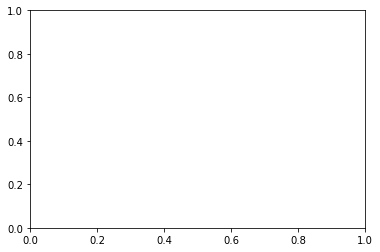

In [186]:
n = 1
N = 2**n
epsilon = 0.3
Rx = getR(epsilon, N)

es_states = []
res_states = []
Rs = []
es = []
res = []

T = getT(epsilon, N)

for R in range(10):
    # full matrix
    circ = QuantumCircuit(n)
    circ.h(range(n))
    # for r in range(1, R+1):
    #     t = r*(T/R)
    #     H0 = np.identity(N) - init_hamiltonian(N)
    #     Hp = np.identity(N) - problem_hamiltonian(N)
    #     circ.append(H_op(T/R,n,(1-f(t,epsilon,N))*H0), range(n))
    #     circ.append(H_op(T/R,n,f(t,epsilon,N)*Hp), range(n))

    # reduced matrix
    res_state = r_v0()
    for r in range(0, R):
        t = r*(T/R)
        H = get_H(a, delt, f(t, epsilon, N))
        res_states.append(res_state)
        res_state = np.dot(H,res_state)

    # res_state = res_state*res_state.conj()

    es_state = Statevector(circ).data
    print(es_state)
    es_states.append(es_state)
    # es_state = es_state*es_state.conj()
    res.append(getREpsilon(res_state, 2))
    # es.append(getEpsilon(st_out(circ, n), N))
    # es.append(getREpsilon(es_state, N))


    Rs.append(R)

plt.plot(Rs, es, label='full')
plt.plot(Rs, res, label='reduce')
# plt.xlim([0, Rx])
plt.xlabel('R')
plt.ylabel('Epsilon')
plt.title('Graph of F(R)')
# plt.ylim([0, 2])
plt.legend()

# print(es)
# print(res)


In [187]:
print(es_states[0])
print(res_states[0])

[0.707+0.j 0.707+0.j]
[1 0]


In [207]:
n = 1
circ = QuantumCircuit(n)
circ.h(range(n))
circ.p(np.pi*(1/2), 0)
# print(Statevector(circ))
m = DensityMatrix(circ)
# print(m)
prob, st_all = la.eig(m.data)
cond = (prob>0.99) & (prob<1.01)
# print(prob)
# print(st_all)
st = st_all[:, cond].ravel()
print(Statevector(circ))
# print(Statevector(st))
print(m.to_statevector().data)

Statevector([7.071e-01+0.j   , 4.330e-17+0.707j],
            dims=(2,))
[1.002e-16-0.707j 7.071e-01+0.j   ]
